In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [ ]:
import gdown
# Google Drive file ID
file_id = "1GXlWLsLNfyLCB53zIxSv9lV1088Uc5ak"

# Output file name
input_file = "accutech_template"

# Download the file
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, input_file, quiet=False)

print(f"File downloaded as {input_file}")

Downloading...
From: https://drive.google.com/uc?id=1GXlWLsLNfyLCB53zIxSv9lV1088Uc5ak
To: /content/accutech_template
100%|██████████| 2.46M/2.46M [00:00<00:00, 189MB/s]

File downloaded as accutech_template


## Preprocessing image to identify contours

In [ ]:
image = cv2.imread(input_file)

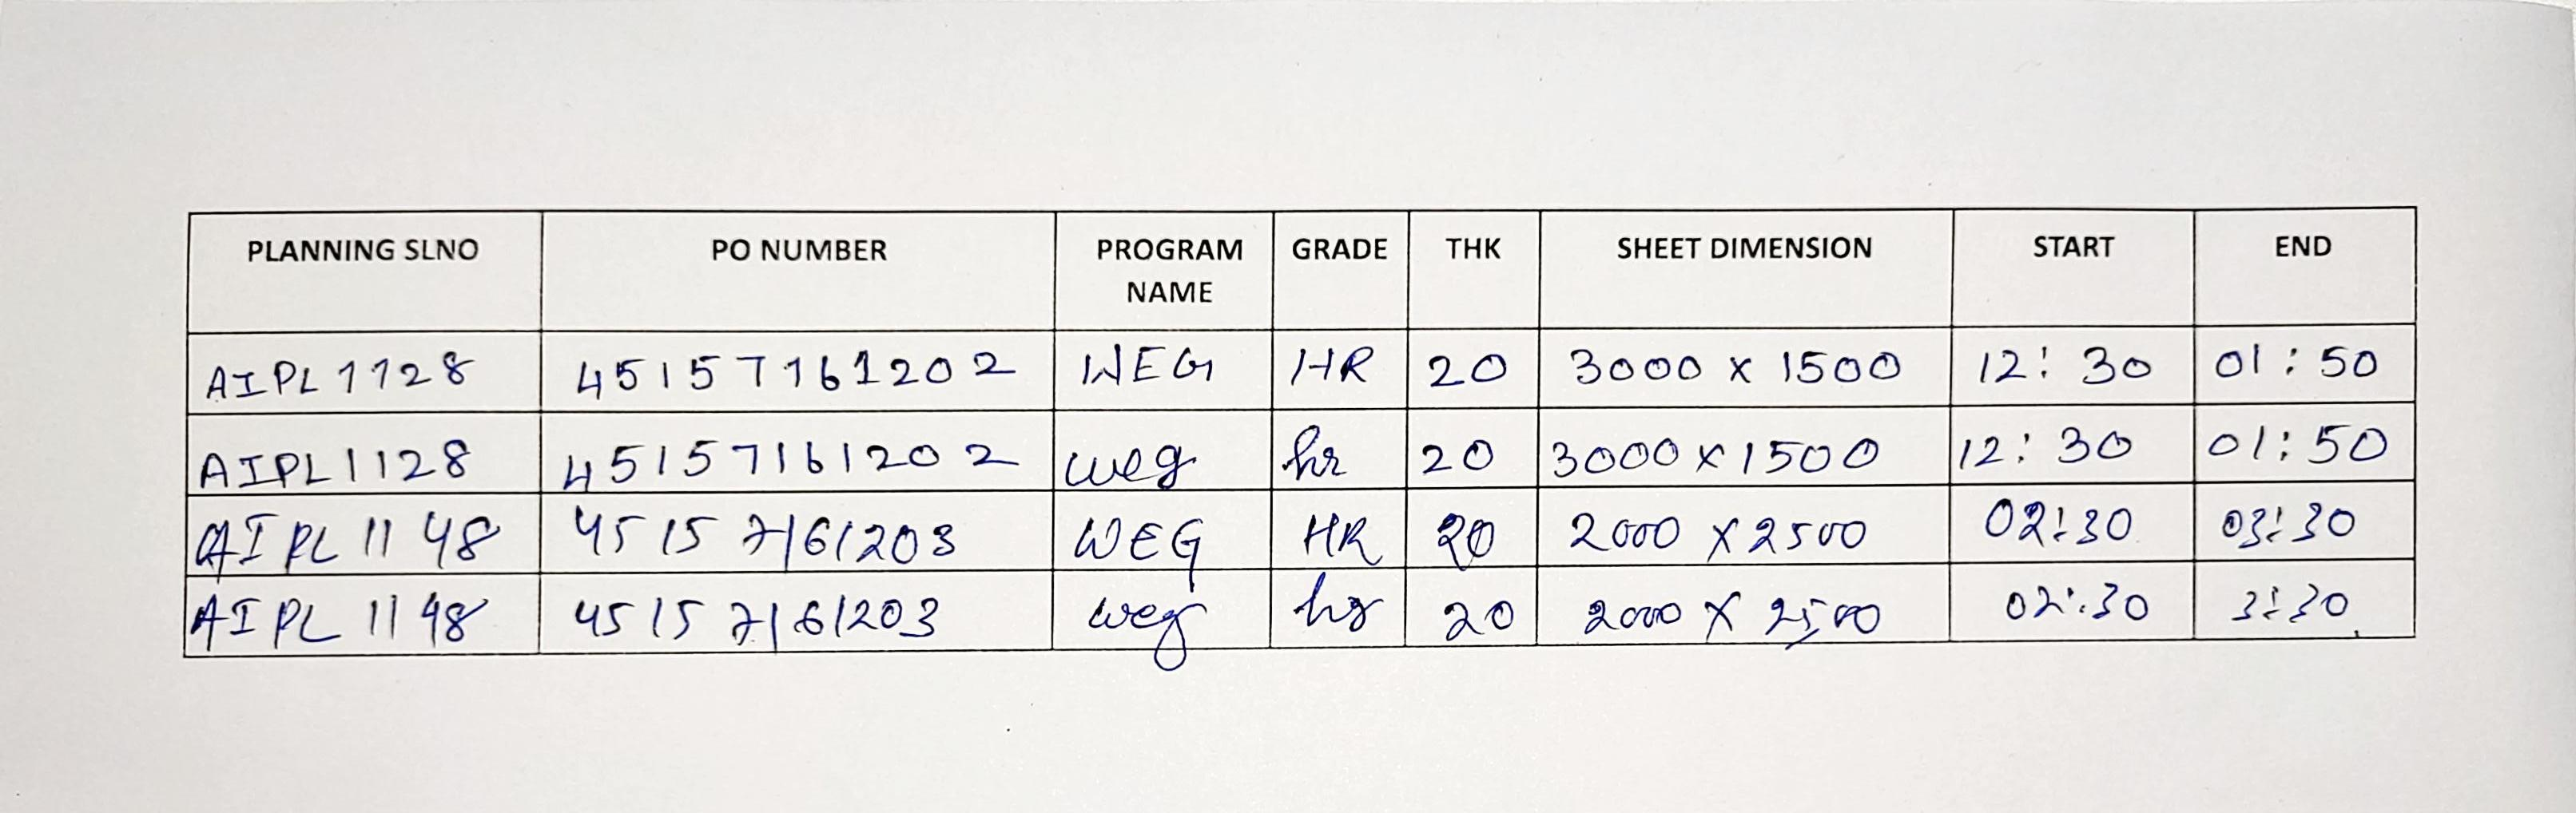

In [ ]:
cv2_imshow(image)

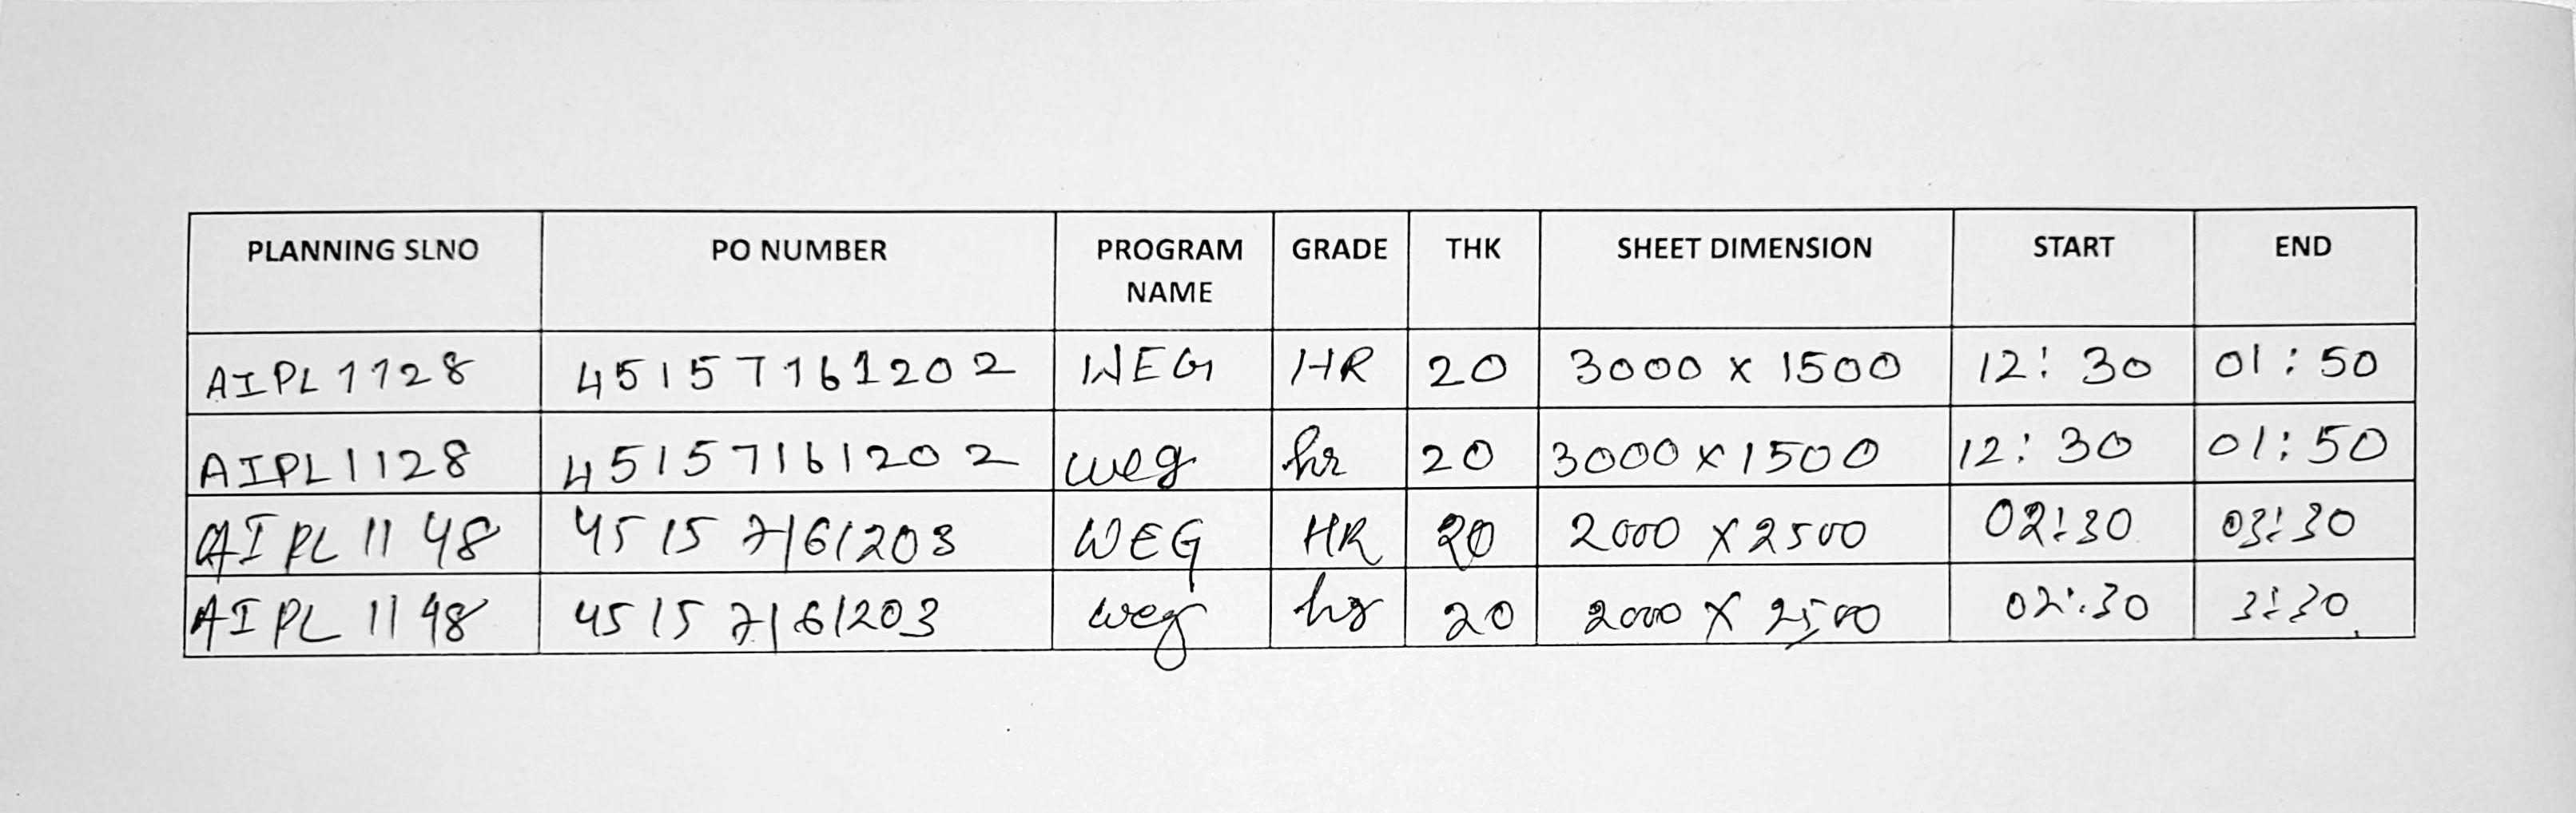

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

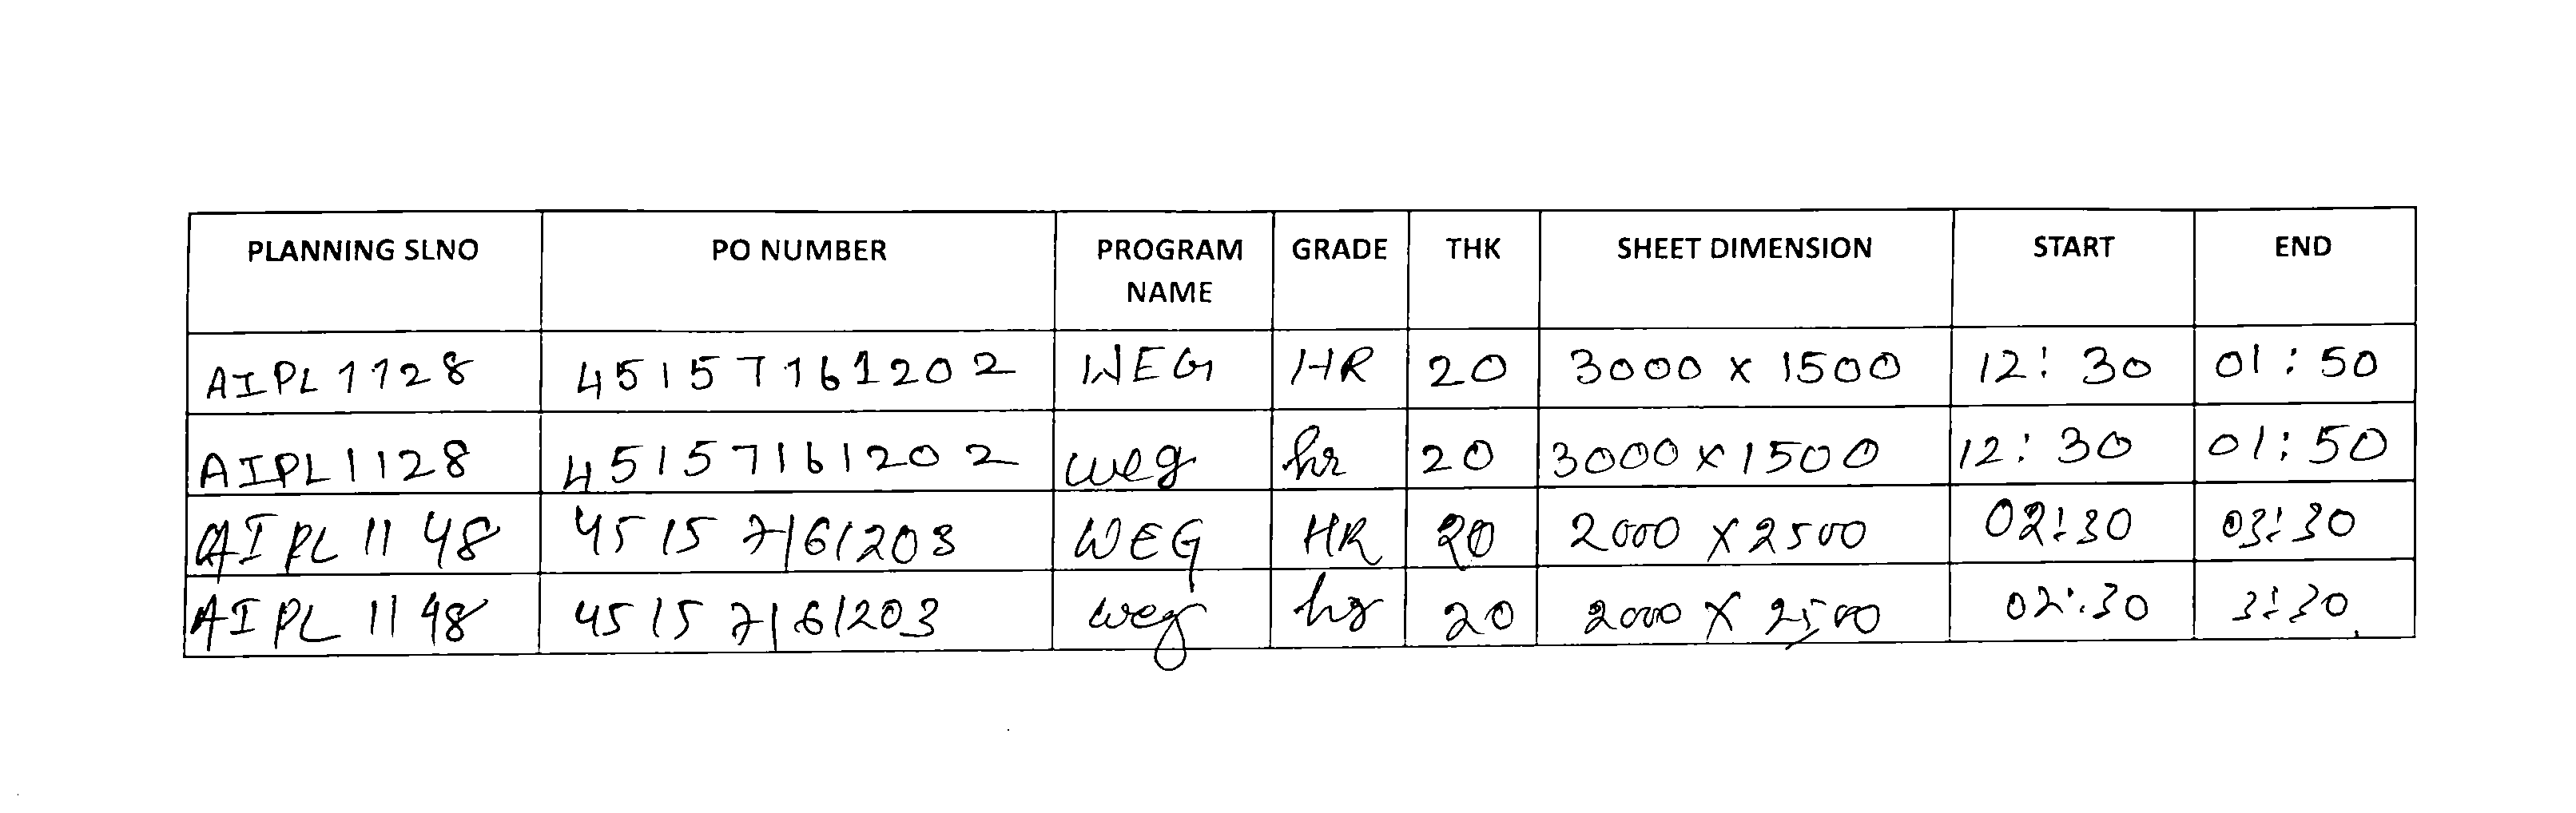

In [ ]:
thresholded_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
cv2_imshow(thresholded_image)

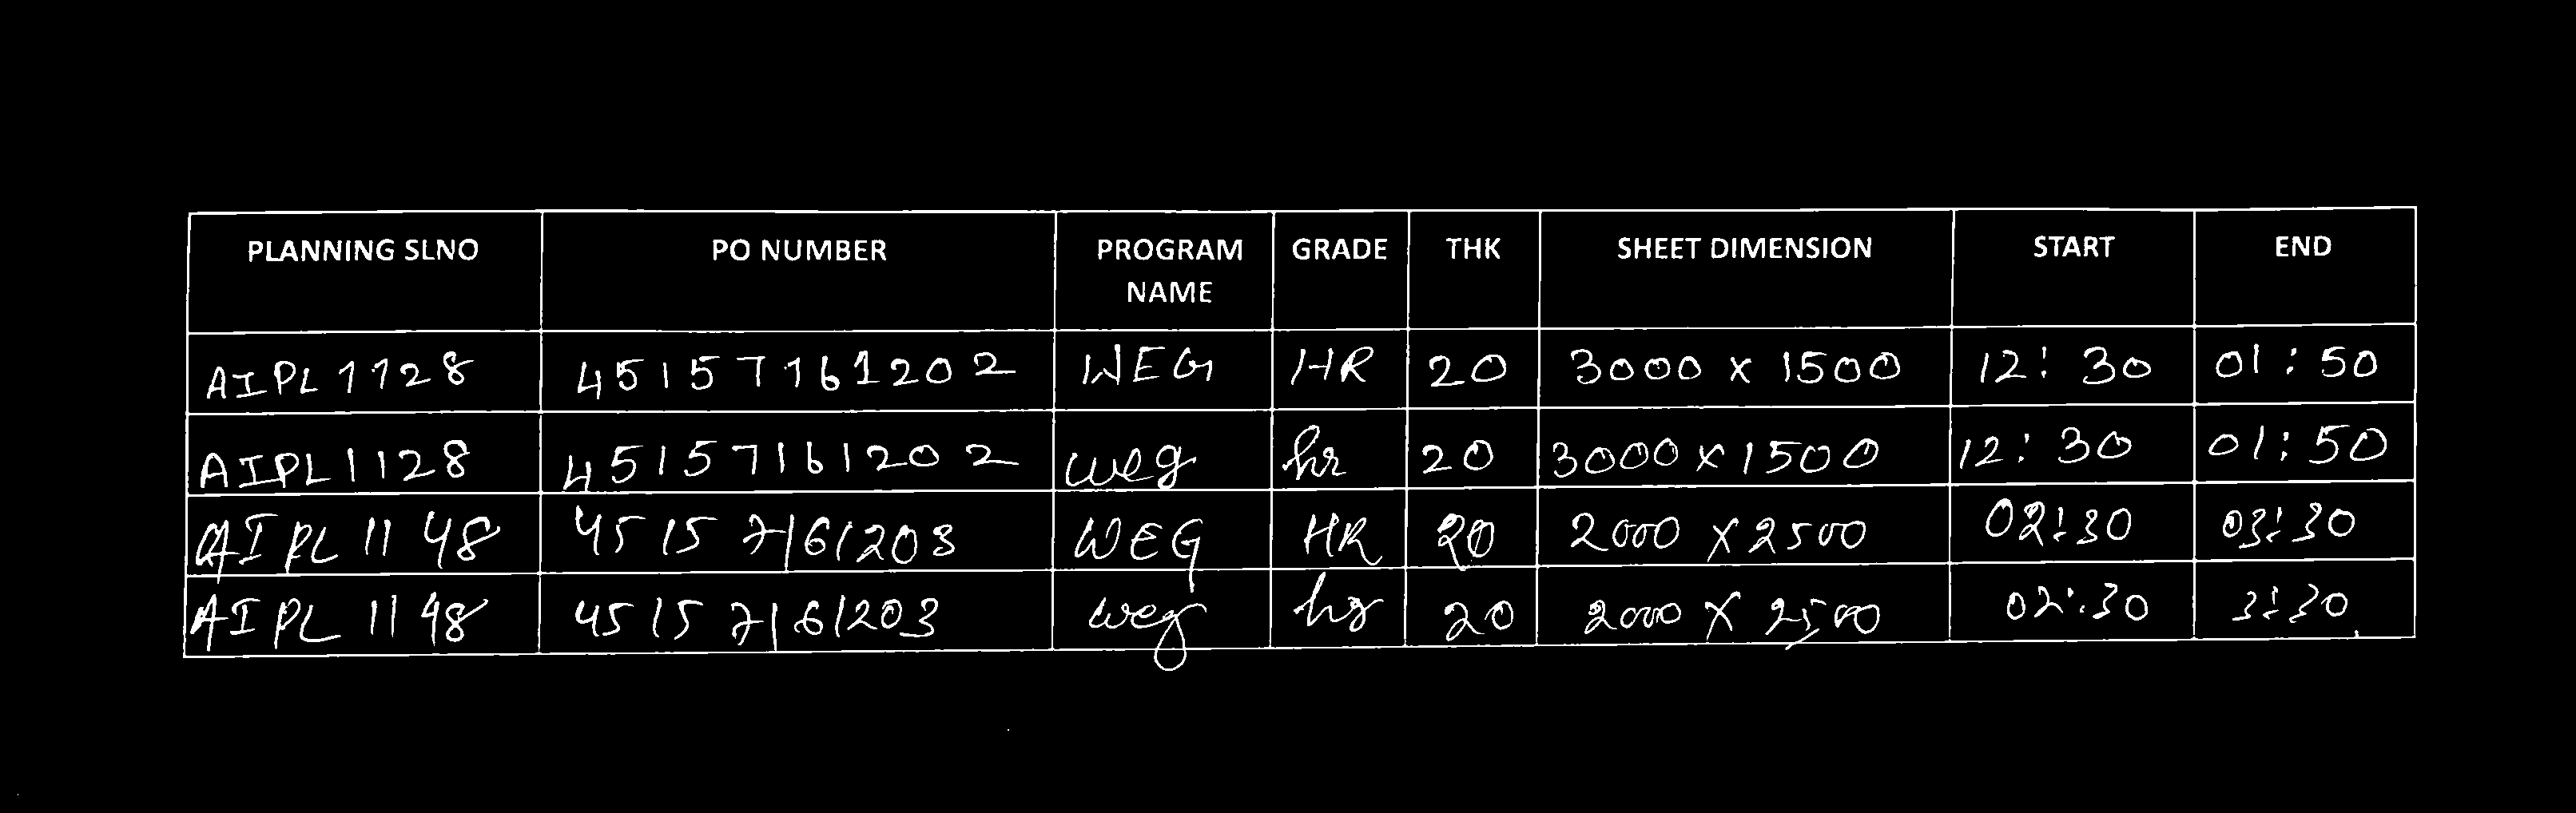

In [ ]:
inverted_image = cv2.bitwise_not(thresholded_image)
cv2_imshow(inverted_image)

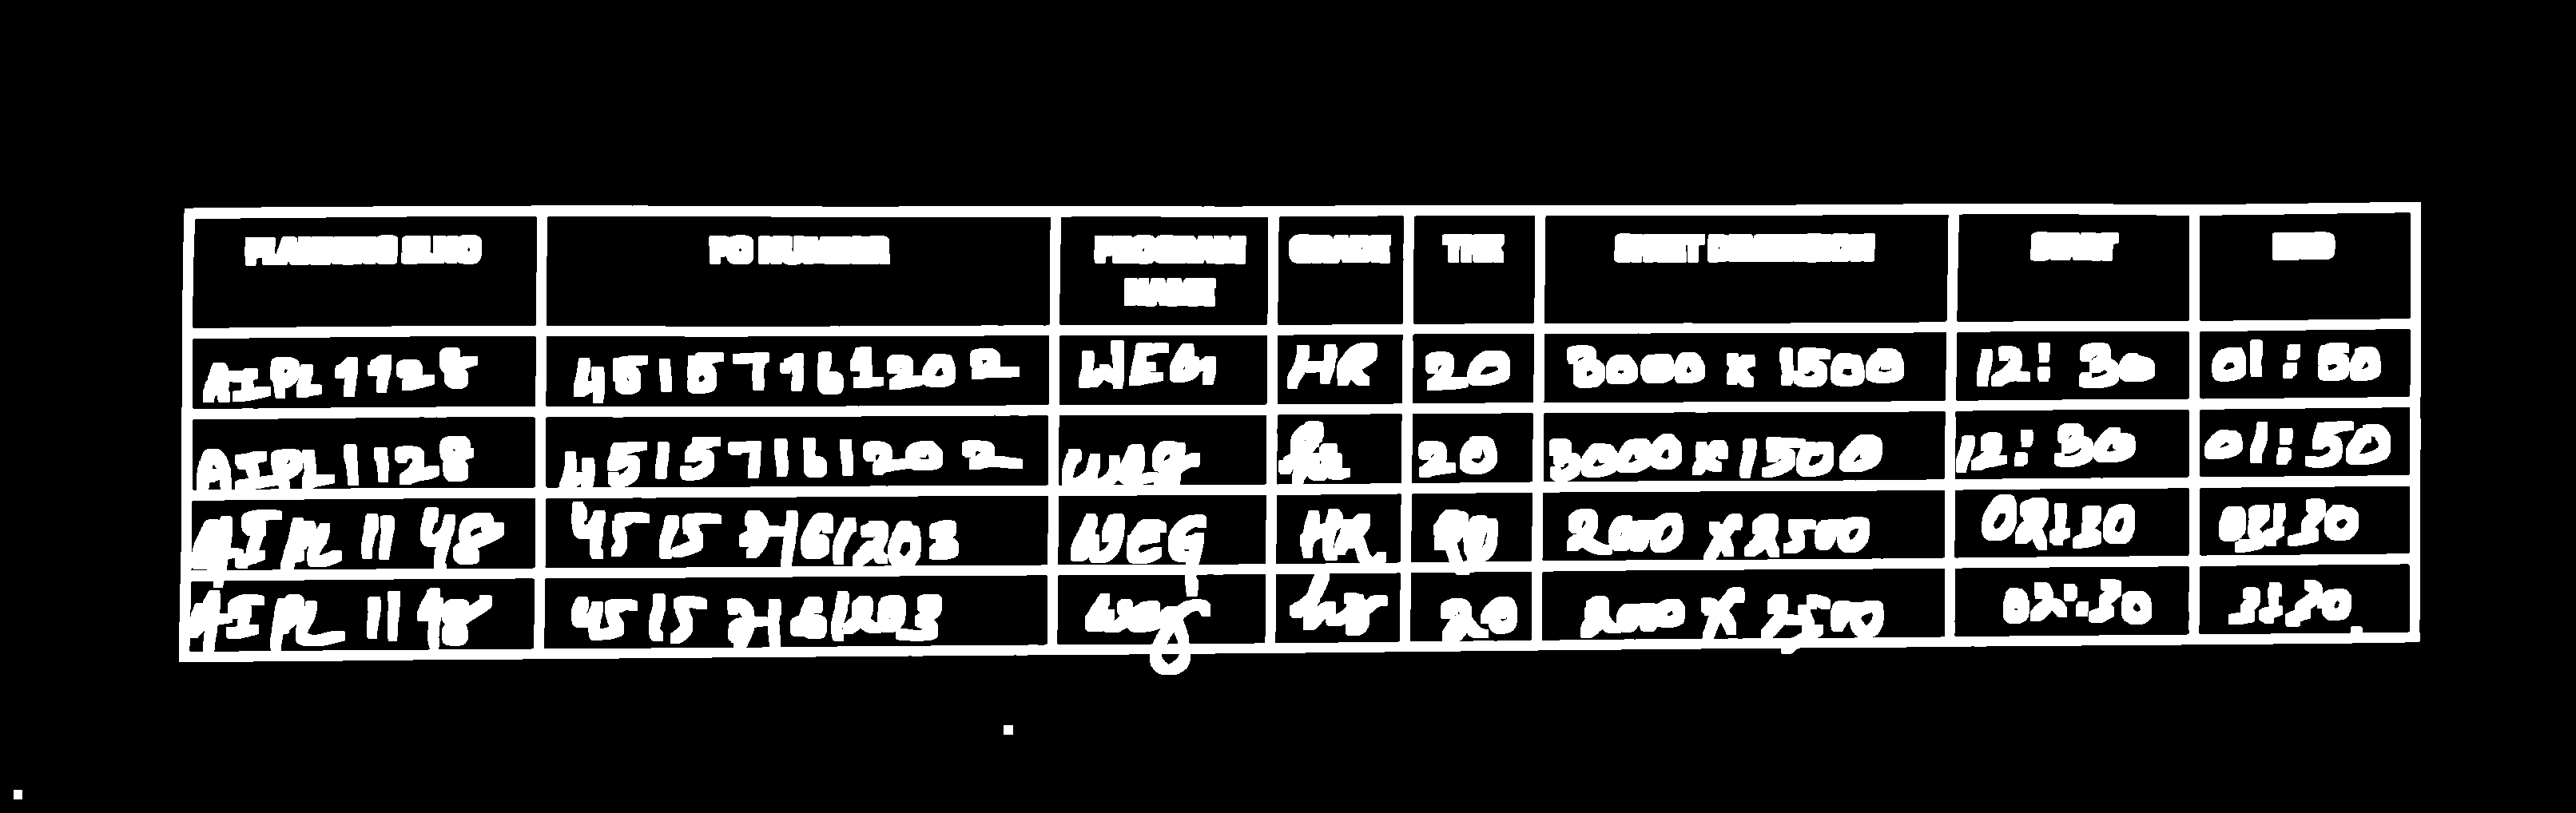

In [ ]:
dilated_image = cv2.dilate(inverted_image, None, iterations = 5)
cv2_imshow(dilated_image)

In [ ]:
# find contours
contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Below lines are added to show all contours
# This is not needed, but it is useful for debugging
image_with_all_contours = image.copy()
cv2.drawContours(image_with_all_contours, contours, -1, (0, 255, 0), 3)

In [ ]:
# Filter contours and leave only rectangles
rectangular_contours = []
for contour in contours:
  peri = cv2.arcLength(contour, True)
  approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
  if len(approx) == 4:
    rectangular_contours.append(approx)
      # Below lines are added to show all rectangular contours
      # This is not needed, but it is useful for debugging
    image_with_only_rectangular_contours = image.copy()
    cv2.drawContours(image_with_only_rectangular_contours, rectangular_contours, -1, (0, 255, 0), 3)

In [ ]:
# find largest contour by area
max_area = 0
contour_with_max_area = None
for contour in rectangular_contours:
    area = cv2.contourArea(contour)
    if area > max_area:
        max_area = area
        contour_with_max_area = contour
# Below lines are added to show the contour with max area
# This is not needed, but it is useful for debugging
image_with_contour_with_max_area = image.copy()
cv2.drawContours(image_with_contour_with_max_area, [contour_with_max_area], -1, (0, 255, 0), 3)

array([[[220, 223, 227],
        [222, 225, 229],
        [221, 224, 228],
        ...,
        [232, 235, 239],
        [227, 230, 234],
        [222, 225, 229]],

       [[220, 223, 227],
        [221, 224, 228],
        [220, 223, 227],
        ...,
        [231, 234, 238],
        [225, 228, 232],
        [219, 222, 226]],

       [[221, 224, 228],
        [221, 224, 228],
        [219, 222, 226],
        ...,
        [230, 233, 237],
        [227, 230, 234],
        [225, 228, 232]],

       ...,

       [[209, 212, 216],
        [209, 212, 216],
        [210, 213, 217],
        ...,
        [208, 211, 215],
        [208, 211, 215],
        [208, 211, 215]],

       [[214, 217, 221],
        [214, 217, 221],
        [214, 217, 221],
        ...,
        [208, 211, 215],
        [208, 211, 215],
        [208, 211, 215]],

       [[214, 217, 221],
        [214, 217, 221],
        [214, 217, 221],
        ...,
        [208, 211, 215],
        [208, 211, 215],
        [208, 211, 215]]

## Perspective correction

In [ ]:
def order_points(pts):
        # initialzie a list of coordinates that will be ordered
        # such that the first entry in the list is the top-left,
        # the second entry is the top-right, the third is the
        # bottom-right, and the fourth is the bottom-left
        pts = pts.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")

        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        # now, compute the difference between the points, the
        # top-right point will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        # return the ordered coordinates
        return rect
def calculateDistanceBetween2Points(p1, p2):
        dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
        return dis

In [ ]:
# Order points in the contour with max area
contour_with_max_area_ordered = order_points(contour_with_max_area)
image_with_points_plotted = image.copy()
for point in contour_with_max_area_ordered:
    point_coordinates = (int(point[0]), int(point[1]))
    image_with_points_plotted = cv2.circle(image_with_points_plotted, point_coordinates, 10, (0, 0, 255), -1)

In [ ]:
# calculate new width and height of image
existing_image_width = image.shape[1]
existing_image_width_reduced_by_10_percent = int(existing_image_width * 0.9)

distance_between_top_left_and_top_right = calculateDistanceBetween2Points(contour_with_max_area_ordered[0], contour_with_max_area_ordered[1])
distance_between_top_left_and_bottom_left = calculateDistanceBetween2Points(contour_with_max_area_ordered[0], contour_with_max_area_ordered[3])

aspect_ratio = distance_between_top_left_and_bottom_left / distance_between_top_left_and_top_right

new_image_width = existing_image_width_reduced_by_10_percent
new_image_height = int(new_image_width * aspect_ratio)

In [ ]:
# apply perspective transform

pts1 = np.float32(contour_with_max_area_ordered)
pts2 = np.float32([[0, 0], [new_image_width, 0], [new_image_width, new_image_height], [0, new_image_height]])
matrix = cv2.getPerspectiveTransform(pts1, pts2)
perspective_corrected_image = cv2.warpPerspective(image, matrix, (new_image_width, new_image_height))

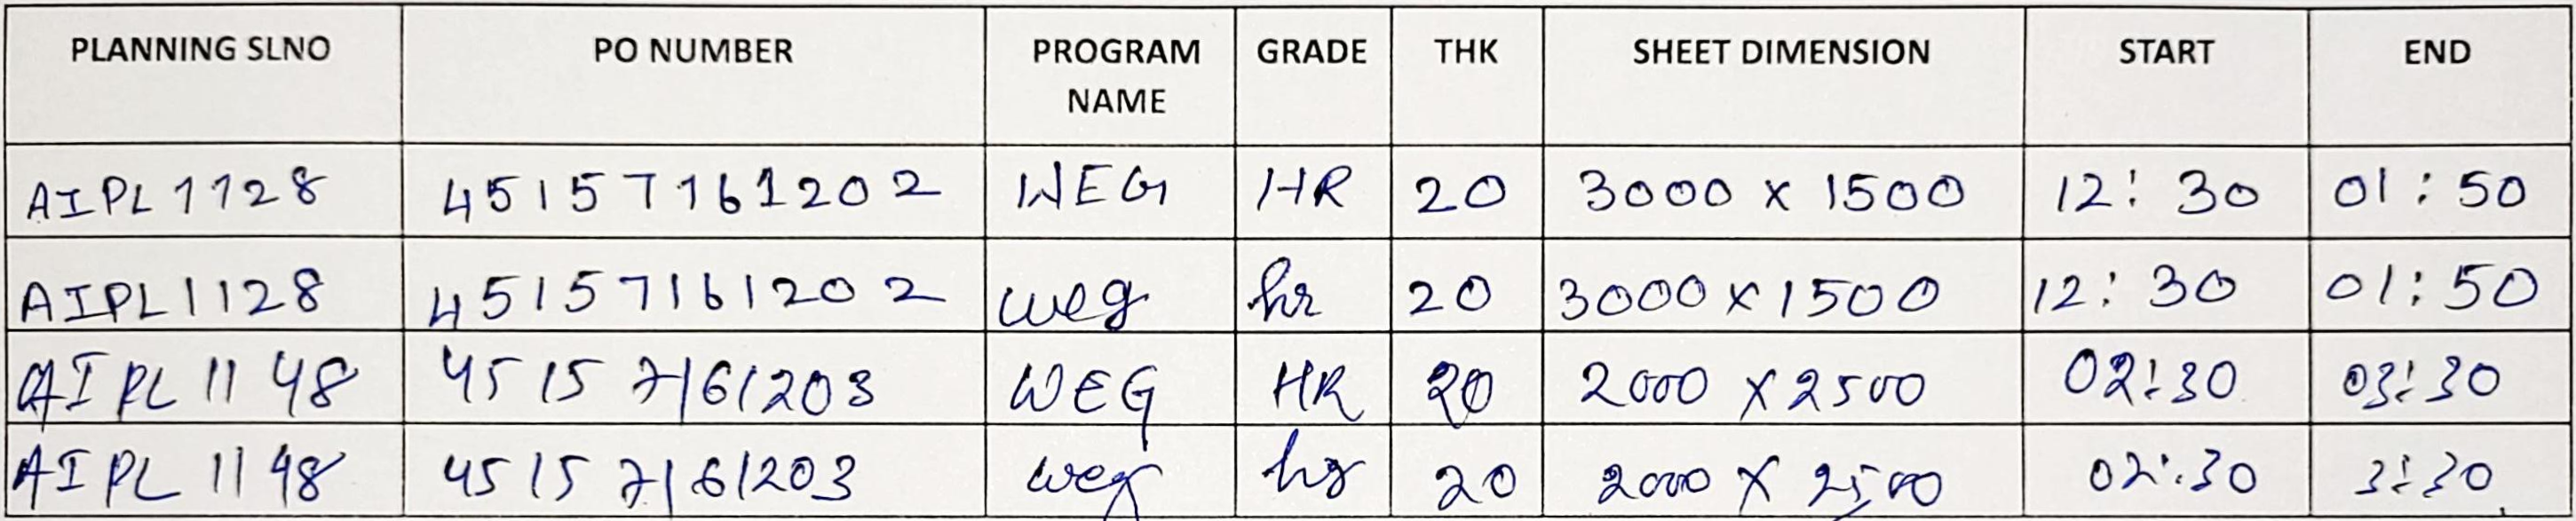

In [ ]:
cv2_imshow(perspective_corrected_image)

## Padding

In [ ]:
# add_10_percent_padding
image_height = image.shape[0]
padding = int(image_height * 0.1)
perspective_corrected_image_with_padding = cv2.copyMakeBorder(perspective_corrected_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])

In [ ]:
# draw_contours
image_with_contours = image.copy()
image_with_contours_padded = cv2.drawContours(image_with_contours,  [contour_with_max_area ], -1, (0, 255, 0), 1)

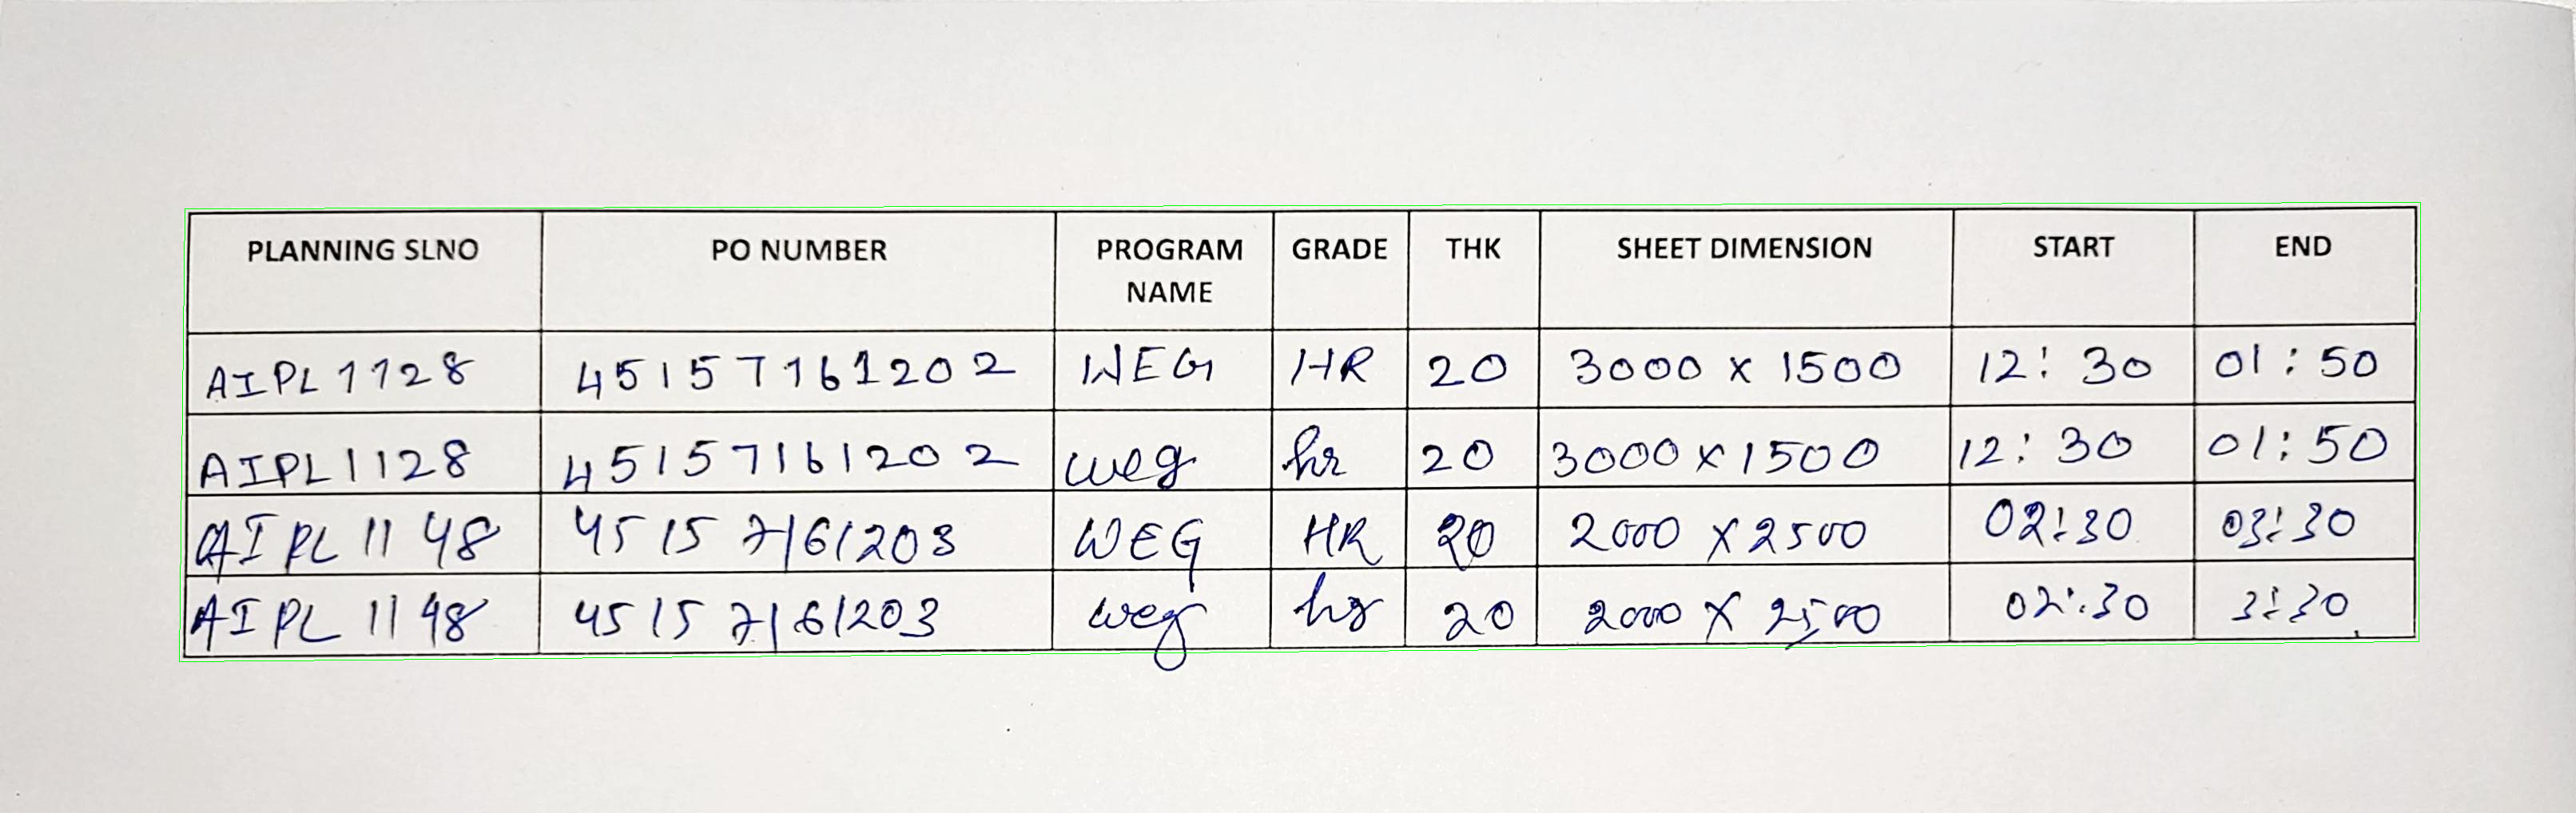

In [ ]:
cv2_imshow(image_with_contours_padded)

## Removing lines